# 1D linearized shallow-water equation with wind stress


In [ ]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.resolve(); Pkg.instantiate(); Pkg.precompile()  # Uncomment if needed for reproducibility

using JLD2, Plots, Statistics, Printf, OrdinaryDiffEq, ComponentArrays, Flux, BSON

  Activating project at `~/Desktop/Deltares/Julia/gpu/wave surges`


In [ ]:
# Model selection
surrogate = 2 
correction = 1

# Setup data 
wind_name = "periodic"   # periodic only (other unstable)
init_state = "flat"      # flat or bump or small_bump
longer = false           # true for longer simulation time 

save_dir = "surrogates/surrogate_$(surrogate)/correction_$(correction))"
nothing

In [3]:
# Load statistics file
stats_file = joinpath(save_dir, "correction_statistics.jld2")
@load stats_file stats_dict

for key in keys(stats_dict)
    @eval ($(Symbol(key)) = stats_dict[$key])
end

# Load model file
model_file = joinpath(save_dir, "corrective_model.bson")
BSON.@load model_file corrective_model

# Load training metrics
metrics_file = joinpath(save_dir, "training_metrics.jld2")
@load metrics_file train_losses_cor scale_history n_epochs_corr learning_rate

# Rename for consistency
train_losses = train_losses_cor

println("✓ Loaded successfully")
@printf "RMSE Corrected: %.6f m\n" rmse_corrected
@printf "Improvement vs Surrogate: %.2f%%\n" improvement_surrogate_pct
@printf "Improvement vs Nominal: %.2f%%\n" improvement_nominal_pct
@printf "SEED: %d\n" SEED

✓ Loaded successfully
RMSE Corrected: 0.010976 m
Improvement vs Surrogate: 74.15%
Improvement vs Nominal: 69.34%
SEED: 6007236083150485430


#### Setup

In [4]:
const DEBUG = true
function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

debug (generic function with 2 methods)

In [ ]:
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

visualize_normalization (generic function with 1 method)

In [ ]:
# utils
function constant_func(t, value=0.0)
    return value
end

function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, Rodas5(), saveat = times, isoutofdomain = (u, p, t) -> any([u.h[i] + D[i] < 0 for i in 1:length(u.h)]), reltol = 1e-8, abstol = 1e-10)

    n_time = length(times)
    n_stat = length(station_idxs)
    H = zeros(n_time, n_stat)
    U = zeros(n_time, n_stat)

    for (i, t) in enumerate(times)
        state = sol(t)
        H[i, :] = state.h[station_idxs]
        U[i, :] = state.u[station_idxs]
    end

    return sol, H, U
end

function make_tau(amplitude=1.0, period=8*3600.0)
    return t -> (amplitude * sin(2π * t / period))^2
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)

q_right (generic function with 1 method)

#### Numerical Simulation and Model Data

In [8]:
if longer 
    @load "data/$(init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

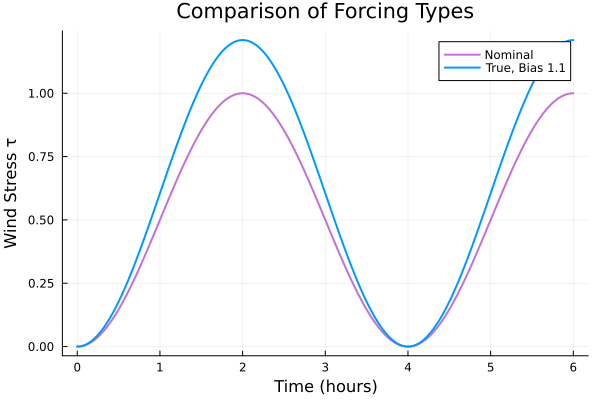

In [9]:
# import wind forcing 
if wind_name == "AR(2)"
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    tau_nominal = make_tau_zero() # amplitude, period
    tau_true = make_tau_zero() # amplitude * bias_factor, period  

elseif wind_name == "constant"
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

# both wind functions compared
p = compare_forcings(Dict("Nominal" => tau_nominal,"True, Bias $bias_factor" => tau_true), times)
display(p)
nothing

In [ ]:
function rollout_surrogate(surrogate_model, h0, u0, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale; n_init_conditions=n_init_conditions)
    # Initialize prediction arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = h0
    u_pred[1,:] = u0

    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Encode initial condition if using multi-IC surrogate
    ic_vec = nothing
    if use_multi_init
        ic_idx = ic_to_idx[correction_init_state]
        ic_vec = zeros(Float32, n_init_conditions)
        ic_vec[ic_idx] = 1.0f0
    end

    # Rollout loop over time steps
    for k in 1:(length(times) - 1)
        # Build raw input vector for this step
        input_vec = Float32[]
        tau_val = Float32(tau_func(times[k]))
        
        # Collect local features for each station
        for i in 1:n_stations
            append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_val, amplitude_scale])
        end

        # Append IC encoding if applicable
        if ic_vec !== nothing
            append!(input_vec, ic_vec)
        end
        
        # Normalize inputs
        input_norm = copy(input_vec)
        input_norm[surrogate_data[:norm_cols_X]] = (input_vec[surrogate_data[:norm_cols_X]] .- mu_X) ./ sigma_X
        input_norm[surrogate_data[:mask_cols_X]] = input_vec[surrogate_data[:mask_cols_X]]
        
        input_col = reshape(Float32.(input_norm), :, 1)

        # Surrogate prediction
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize output
        pred_unnorm = copy(pred_vec)
        pred_unnorm[surrogate_data[:norm_cols_Y]] = pred_vec[surrogate_data[:norm_cols_Y]] .* sigma_Y .+ mu_Y

        # Update state
        if surrogate_data[:predict_increment]
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end

    return h_pred, u_pred  
end

rollout_surrogate (generic function with 1 method)

In [ ]:
# Load model parameters
if false 
    @load "surrogates/$(init_state)_surrogate$(surrogate)_$(wind_name)_longer$(longer)" surrogate_model H_surrogate U_surrogate surrogate_data
else   
    if longer 
        @load "data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2" surrogate_model H_surrogate surrogate_data
    else 
        @load "data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate).jld2" surrogate_model H_surrogate surrogate_data
    end 
end 

# Rollout surrogate model
use_multi_init = isa(surrogate, AbstractDict) ? get(surrogate, :use_multi_init, false) : false

if use_multi_init
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, surrogate_data[:mu_X], 
                                                surrogate_data[:sigma_X], surrogate_data[:mu_Y], surrogate_data[:sigma_Y],
                                                surrogate_data[:D_stations], surrogate_data[:mask], surrogate_data[:n_stations], 1.0f0)
else
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, surrogate_data[:mu_X], 
                                                surrogate_data[:sigma_X], surrogate_data[:mu_Y], surrogate_data[:sigma_Y],
                                                surrogate_data[:D_stations], surrogate_data[:mask], surrogate_data[:n_stations], 1.0f0, n_init_conditions=nothing)
end 
nothing

#### Correction Results 

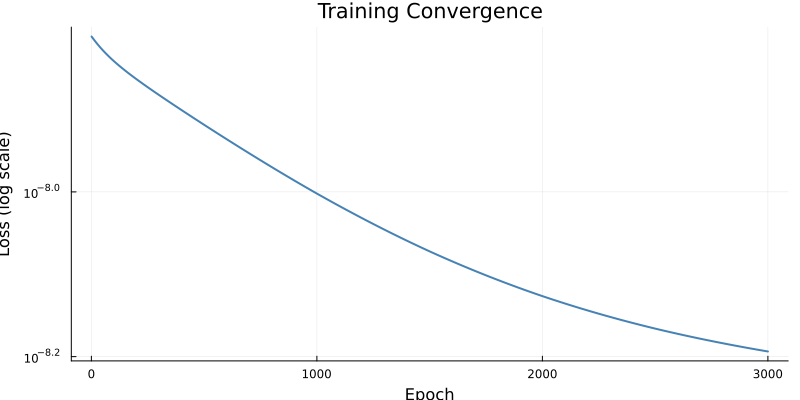

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/correction/surrogate2/2/results_flat_s2_periodic_false/img/training_convergence.png"

In [ ]:
# Plot training convergence
p_train = plot(train_losses, yscale=:log10, xlabel="Epoch", ylabel="Loss (log scale)", color=:steelblue, 
                title="Training Convergence", linewidth=2, legend=false, size=(800, 400))
display(p_train)
savefig(p_train, joinpath(save_dir, "img/training_convergence.png"))

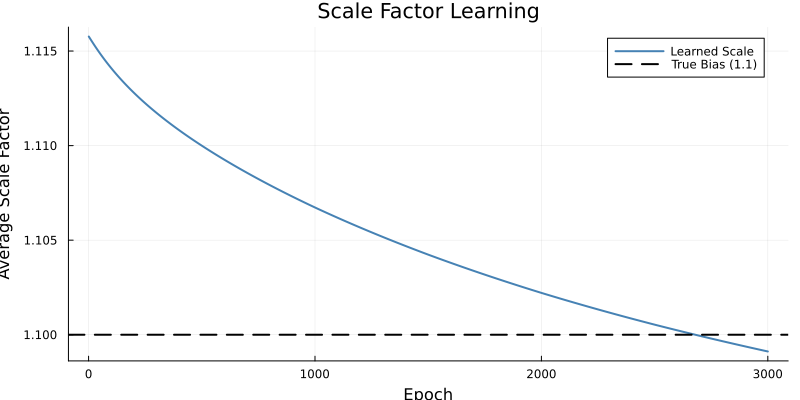

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/correction/surrogate2/2/results_flat_s2_periodic_false/img/scale_evolution.png"

In [ ]:
# Plot scale factor evolution during training
p_scale = plot(scale_history, xlabel="Epoch", ylabel="Average Scale Factor", color=:steelblue,
                title="Scale Factor Learning", linewidth=2, label="Learned Scale", size=(800, 400))
hline!([bias_factor], label="True Bias ($bias_factor)", linestyle=:dash, linewidth=2, color=:black)
display(p_scale)
savefig(joinpath(save_dir, "img/scale_evolution.png"))


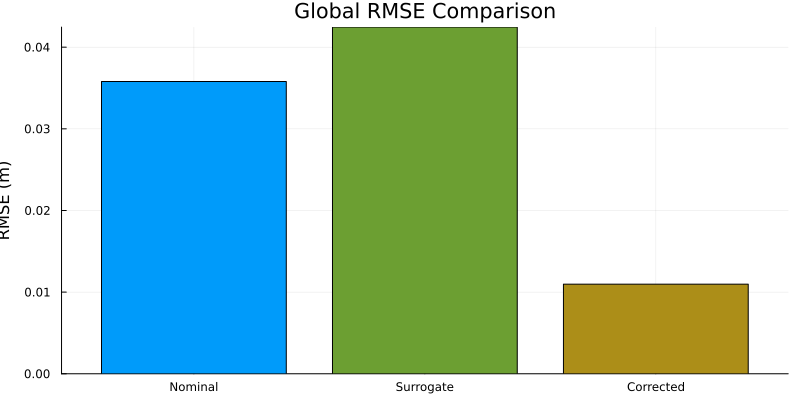

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/correction/surrogate2/2/results_flat_s2_periodic_false/img/rmse_comparison.png"

In [ ]:
# Global RMSE comparison plot
p_rmse = bar(["Nominal", "Surrogate", "Corrected"], [rmse_nominal, rmse_surrogate, rmse_corrected], ylabel="RMSE (m)", 
              title="Global RMSE Comparison", legend=false, color=[cur_colors[1], cur_colors[end], cur_colors[5]], size=(800, 400))
display(p_rmse)
savefig(p_rmse, joinpath(save_dir, "img/rmse_comparison.png"))

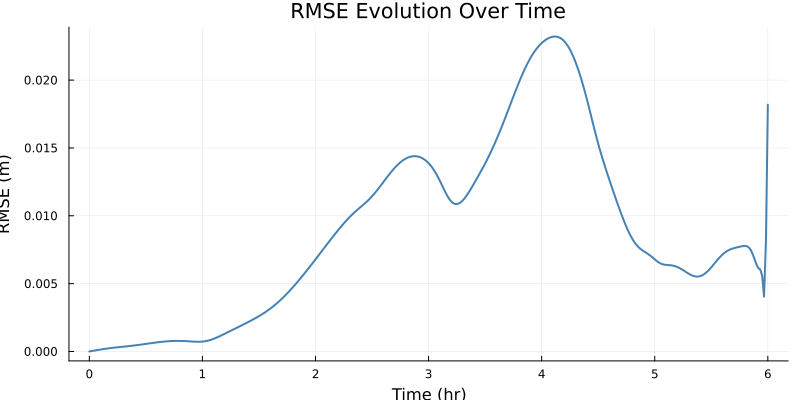

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/correction/surrogate2/2/results_flat_s2_periodic_false/img/rmse_timeseries.png"

In [ ]:
# RMSE evolution over time plot
times_hours = times[1:length(rmse_corrected_time)] ./ 3600

p_rmse_t = plot(times_hours, rmse_corrected_time, xlabel="Time (hr)", ylabel="RMSE (m)", 
                title="RMSE Evolution Over Time", linewidth=2, legend=false, size=(800, 400), color=:steelblue)
display(p_rmse_t)
savefig(p_rmse_t, joinpath(save_dir, "img/rmse_timeseries.png"))

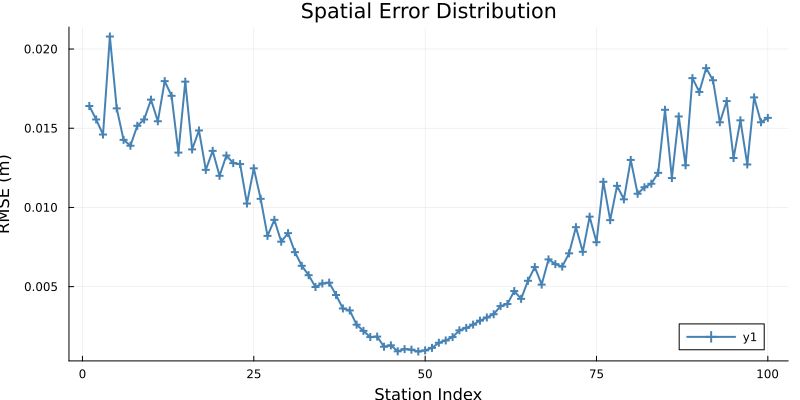

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/correction/surrogate2/2/results_flat_s2_periodic_false/img/spatial_errors.png"

In [ ]:
if !global_scale
    # Spatial error distribution plot
    n_stations = size(H_corrected, 2)
    p_spatial = plot(1:n_stations, rmse_corrected_station, xlabel="Station Index", ylabel="RMSE (m)", 
                     color=:steelblue, title="Spatial Error Distribution", linewidth=2, marker=:cross, size=(800, 400))
    display(p_spatial)
    savefig(p_spatial, joinpath(save_dir, "img/spatial_errors.png"))
end

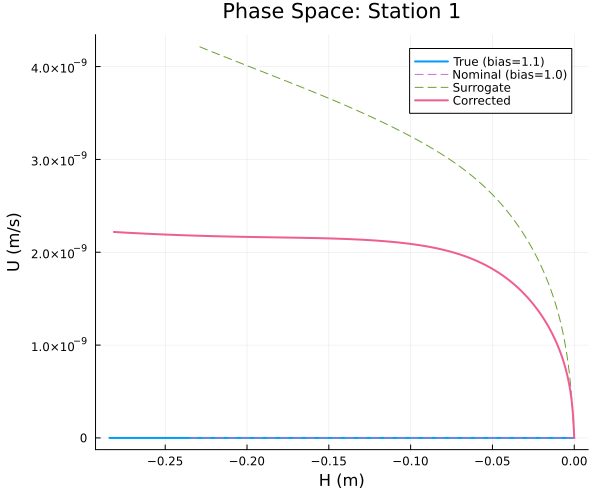

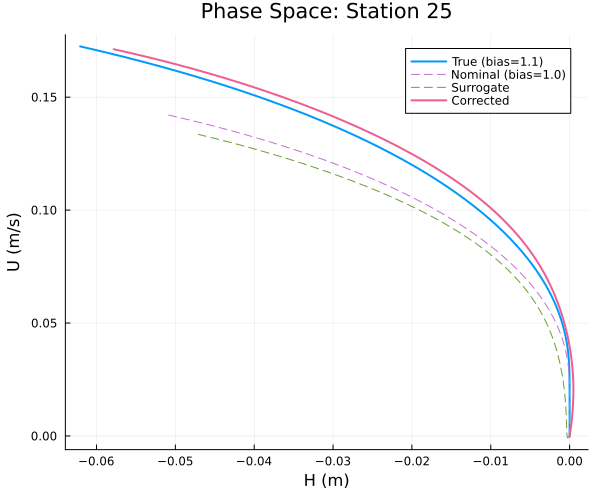

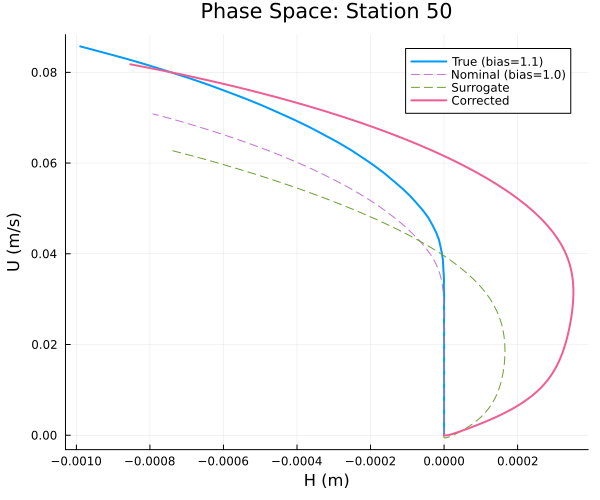

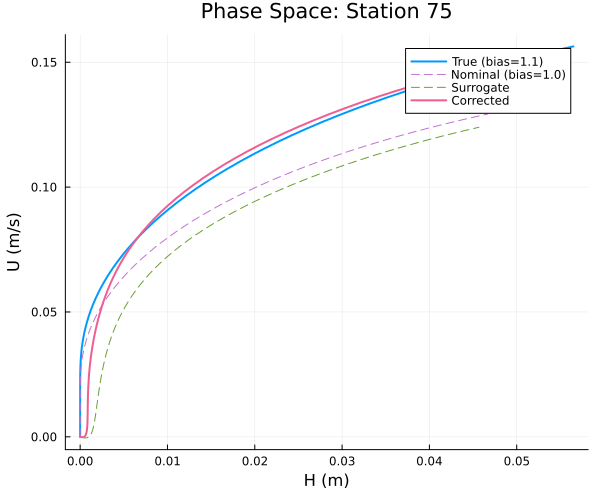

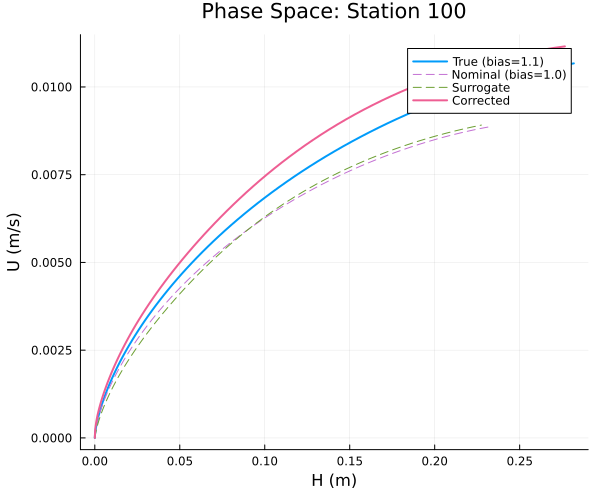

In [ ]:
# Phase space plots for selected stations
stations_to_plot = [1, 25, 50, 75, 100]
time_range = 1:100  # First 100 timesteps

for station_idx in stations_to_plot
    p_phase = plot(xlabel="H (m)", ylabel="U (m/s)", title="Phase Space: Station $station_idx", 
        legend=:topright, size=(600, 500))
    
    plot!(H_true[time_range, station_idx], U_true[time_range, station_idx], label="True (bias=$bias_factor)", linewidth=2)
    plot!(H_nominal[time_range, station_idx], U_nominal[time_range, station_idx], label="Nominal (bias=1.0)", linestyle=:dash, color=cur_colors[4])
    plot!(H_surrogate[time_range, station_idx], U_surrogate[time_range, station_idx],  label="Surrogate", linestyle=:dash, color=cur_colors[end])
    plot!(H_corrected[time_range, station_idx], U_corrected[time_range, station_idx], label="Corrected", linewidth=2, color=cur_colors[7])
    display(p_phase)
    savefig(joinpath(save_dir, "img/phase_space_station$(station_idx).png"))
end


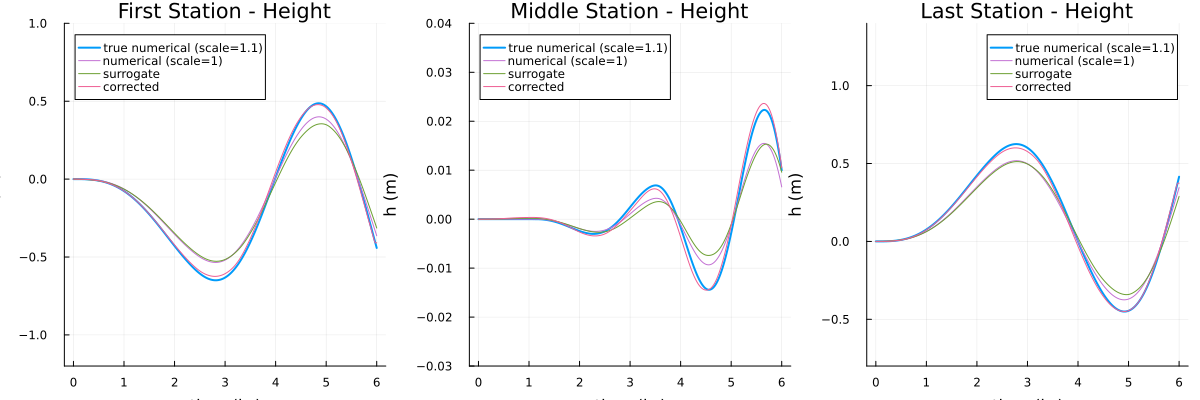

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/correction/surrogate2/2/results_flat_s2_periodic_false/img/correction_rollout_3panel.png"

In [ ]:
# Correction rollout 3-panel comparison plot
stations = [station_idxs[1], station_idxs[end÷2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.03, 0.04), (-0.8, 1.4)]
titles = ["First Station - Height", "Middle Station - Height", "Last Station - Height"]

plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
    plot!(plt[i], times ./ 3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

display(plt)
savefig(joinpath(save_dir, "img/correction_rollout_3panel.png"))

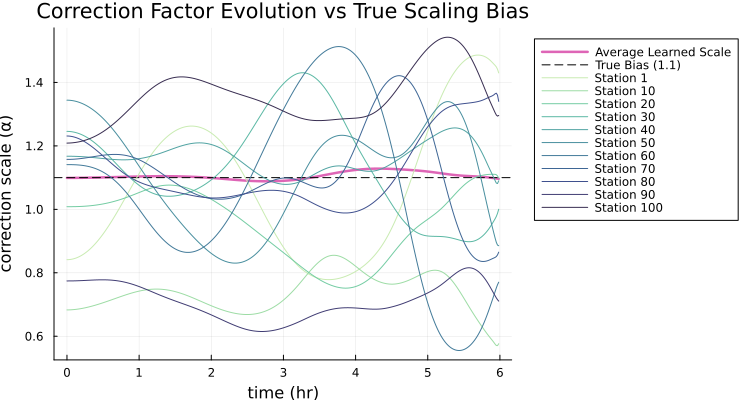

In [ ]:
if global_scale
    # For global scale case
    p = plot(times[1:end-1] ./ 3600, scale_series, label="Global Correction Factor", linewidth=2, color=cur_colors[11])
    hline!([bias_factor], label="True Bias ($bias_factor)", ls=:dash, linewidth=2, color=:black)
    
    xlabel!("Time (hr)"); ylabel!("Correction Scale (α)"); title!("Global Correction Factor Evolution vs True Scaling Bias")
    savefig(p, joinpath(save_dir, "global_correction_factor.png"))
    display(p)
else
    # For per-station case 
    grad = cgrad(:deep)
    typical_stations = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    colors = [grad[i] for i in range(0.1, stop=0.9, length=length(typical_stations))]
    labels = ["Station $(s)" for s in typical_stations]
    
    # Compute average scale (mean across stations at each time step)
    avg_scale = [mean(alpha_vec) for alpha_vec in scale_series]
    p = plot(times[1:end-1] ./ 3600, avg_scale, label="Average Learned Scale", linewidth=2.5, color=cur_colors[end-1], legend=:outertopright, size=(750,400))
    hline!([bias_factor], label="True Bias ($bias_factor)", ls=:dash, linewidth=1, color=:black)
    
    # Plot individual station alphas
    for (i, station_idx) in enumerate(typical_stations)
        if haskey(alpha_series, station_idx) && !isempty(alpha_series[station_idx])
            plot!(p, times[1:end-1] ./ 3600, alpha_series[station_idx], label=labels[i], linewidth=1.0, color=colors[i])
        end
    end
    
    xlabel!(p, "time (hr)"); ylabel!(p, "correction scale (α)"); title!(p, "Correction Factor Evolution vs True Scaling Bias")
    savefig(p, joinpath(save_dir, "correction_alpha_bias_surrogate$(surrogate)_$(longer).png"))
    display(p)
end


In [23]:
println("\n" * "-"^70)
println("STATISTICAL SUMMARY")
println("-"^70)

println("\nConfiguration:")
println("  surrogate:              $surrogate")
println("  wind_name:              $wind_name")
println("  init_state:             $correction_init_state")
println("  longer:                 $longer")
println("  global_scale:           $global_scale")
println("  complete_input:         $complete_input")
println("  predict_increment:      $predict_increment")
println("  predict_scale_increment: $predict_scale_increment")
println("  use_multi_data:         $use_multi_data")
println("  use_multi_init:         $use_multi_init")

println("\nPerformance:")
@printf("  RMSE Nominal:       %.6f m\n", rmse_nominal)
@printf("  RMSE Surrogate:     %.6f m\n", rmse_surrogate)
@printf("  RMSE Corrected:     %.6f m\n", rmse_corrected)



----------------------------------------------------------------------
STATISTICAL SUMMARY
----------------------------------------------------------------------

Configuration:
  surrogate:              2
  wind_name:              periodic
  init_state:             flat
  longer:                 false
  global_scale:           false
  complete_input:         true
  predict_increment:      true
  predict_scale_increment: true
  use_multi_data:         true
  use_multi_init:         false

Performance:
  RMSE Nominal:       0.035796 m
  RMSE Surrogate:     0.042462 m
  RMSE Corrected:     0.010976 m


In [24]:
# improvement_nominal_pct and improvement_surrogate_pct already loaded
println("\nImprovements:")
@printf("  vs Surrogate:       %+.2f%%\n", improvement_surrogate_pct)
@printf("  vs Nominal:         %+.2f%%\n", improvement_nominal_pct)

println("\nScale Statistics:")
final_alpha_mean = mean(mean(values(alpha_series)))
alpha_error = abs(final_alpha_mean - bias_factor)

@printf("  Final Alpha Mean: %.4f\n", final_alpha_mean)
@printf("  Target:           %.4f\n", bias_factor)
@printf("  Error:            %.4f\n", alpha_error)

println("\nTraining:")
@printf("  Epochs:           %d\n", n_epochs_corr)
@printf("  Learning Rate:    %.6f\n", learning_rate)
@printf("  K (unrolling):    %d\n", K_global)
@printf("  Seed:             %d\n", SEED)



Improvements:
  vs Surrogate:       +74.15%
  vs Nominal:         +69.34%

Scale Statistics:
  Final Alpha Mean: 1.0485
  Target:           1.1000
  Error:            0.0515

Training:
  Epochs:           3000
  Learning Rate:    0.000010
  K (unrolling):    2
  Seed:             6007236083150485430
